# Object Detection with using OpenCV DNN Interface

In this tutorial, I will go through using OpenCV deep learning inference API for object detection sample from a given image. I will try to give instructions how to get models and configure OpenCV in order to get object information from images. 

### What is Caffe ? 

**Caffe**:  Caffe is a deep learning framework made with expression, speed, and modularity in mind. It is developed by Berkeley AI Research (BAIR) and by community contributors. Yangqing Jia created the project during his PhD at UC Berkeley. Caffe is released under the BSD 2-Clause license. 

http://caffe.berkeleyvision.org/

In this tutorial we will go through object detection using OpenCV and pre-trained model from Caffe Framework. OpenCV DNN library is able to make inference call with pretrained models from Caffe Framework.

https://github.com/opencv/opencv/tree/master/samples/dnn

In later sections, we will download a deep learning model for object detection trained with Caffe framework and custom network and detection models to try it out with OpenCV. OpenCV loads pre-trained models to complete object detection process, this is called inference.

### What is Tensorflow ? 

**Tensorflow**: TensorFlow™ is an open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices. Originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains. 

https://www.tensorflow.org/

Tensorflow helps researchers to work with large datasets including images, to generate neural nets trained for a specific purpose to reuse them for particular applications. Here we will use one of the model generated using Tensorflow using OpenCV DNN API to infer objects in a given image.

In [1]:
# lets first import numpy, cv and tensorflow libraries
import numpy as np
import cv2 as cv

%matplotlib inline
import matplotlib.pyplot as plt

import time

### Training Models

Creating DNN Models is an exhaustive and quite complicated process. It includes feature extraction, having a large set of training images to identify certain object in images as true or false until a neural network is constructed.

Here is an end to end tutorial from Caffe framework to use deep learning for computer vision: https://docs.google.com/presentation/d/1UeKXVgRvvxg9OUdh_UiC5G71UMscNPlvArsWER41PsU/edit#slide=id.gc2fcdcce7_216_0

### Caffe Models

Caffe is especially useful for convolutional neural networks and CNNs are very efficient for computer vision processing. CNNs are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity.

Caffe Model Zoo, has plenty of sample pre-trained models in https://github.com/BVLC/caffe/wiki/Model-Zoo. These models have been trained by a lot researchers around the world with different set of training data sets and served with open source license.

In this tutorial, I selected the populat nueral net configuration called Mobile Net.

#### Mobile Net

A class of efficient models called MobileNets for mobile and embedded vision applications. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. We introduce two simple global hyper-parameters that efficiently trade off between latency and accuracy. These hyper-parameters allow the model builder to choose the right sized model for their application based on the constraints of the problem.

Here is the research paper of Mobile Net.
- https://arxiv.org/abs/1704.04861

#### SSD (Single Shot Multibox Detector)

SSD is an unified framework for object detection with a single network. This defines the structure of neural net. MobileNet is a image classifier, specifically designed for mobile and embedded vision. 

"A method for detecting objects in images using a single deep neural network. Our approach, named SSD, discretizes the output space of bounding boxes into a set of default boxes over different aspect ratios and scales per feature map location. At prediction time, the network generates scores for the presence of each object category in each default box and produces adjustments to the box to better match the object shape. Additionally, the network combines predictions from multiple feature maps with different resolutions to naturally handle objects of various sizes."

- https://arxiv.org/abs/1512.02325

- https://github.com/weiliu89/caffe/tree/ssd

A widely used MobileNetSDD Network and Weights can be accessed from following URL.

Model and Proto file can be accessed from: https://github.com/chuanqi305/MobileNet-SSD

Model's visual recognition, are trained with MS-COCO open source image set, any known image set. After all training process, you would have a model file which stores neural net's configurations and proto file to define network itself.

#### Some DNN Terms

- weights (or kernels, filters, parameters, or feature extractors)
- blob - a 4 dimensional data structure, i.e., a 4D tensor, that contains data, gradients, or weights (including biases)
- neurons - performs a non-linear transformation on a data blob
- feature maps (others call them channels)
- inference

#### Model File

Binary file generated by Caffe framework after traninig to reuse along with all different platforms. Underlying data is the neural net configurations and weights.

#### Proto

Human readable text file used for training of models and define the Convolutional Neural Networks parameters and configurations.

In this example, we will use MobileNetSSD models generated with Caffe framework and will use OpenCV Caffe model inference for object detection.

**Before going forward download model and proto files to model folder.**

- https://github.com/chuanqi305/MobileNet-SSD/blob/master/MobileNetSSD_deploy.caffemodel?raw=true
- https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/MobileNetSSD_deploy.prototxt

Note: you can wget to download files from terminal

```shell
wget -O <path_to_download>/MobileNetSSD_deploy.prototxt https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/MobileNetSSD_deploy.prototxt

wget -O <path_to_download>/MobileNetSSD_deploy.caffemodel https://github.com/chuanqi305/MobileNet-SSD/blob/master/MobileNetSSD_deploy.caffemodel?raw=true
```

In [2]:
# here is the caffe models paths
caffe_model = 'dnn_models/MobileNetSSD_deploy.caffemodel'
caffe_proto = 'dnn_models/MobileNetSSD_deploy.prototxt'

#caffe model labels for objects are predefined for MobileNetSSD caffe model and protbuf.
# Existing model exported from the above source, has been trained for below objects.

labels = ("background", "aeroplane", "bicycle", 
          "bird", "boat", "bottle", "bus", 
          "car", "cat", "chair", "cow", 
          "diningtable", "dog", "horse", 
          "motorbike", "person", "pottedplant", 
          "sheep", "sofa", "train", "tvmonitor")

#label_colors = np.random.uniform(0, 255, (len(labels),3))
# we generated random colors for each label to determine object on frame
label_colors = [[ 70.03036239,  53.39948712, 221.96066983],
                   [ 72.40459246,  81.85653543, 216.79091508],
                   [ 16.05095266, 156.74660586,  28.22137944],
                   [ 22.14580474, 245.30084464, 203.24240217],
                   [ 67.87645208,  61.44175277,  62.59789847],
                   [252.36723978,   5.40010433,  73.84552673],
                   [207.95470272,  96.58437259,  17.00872131],
                   [108.9367236 , 180.97081026,  78.16660705],
                   [237.0586842 , 160.01565458, 106.49361722],
                   [131.40428931,  43.9492775 , 222.22671871],
                   [109.40802485, 123.90466382, 208.49082336],
                   [241.25056538, 246.46355905, 215.40549655],
                   [ 50.53963961, 188.7669464 ,  14.91525421],
                   [104.91164983,  13.90156432,  80.97275078],
                   [ 65.87683959, 160.34697271, 199.46650188],
                   [ 16.08423214,  84.441482  , 163.3640731 ],
                   [ 68.50589207,  65.21968418, 229.81699866],
                   [151.91579089, 195.49198107,  94.49696933],
                   [132.74947445,  14.51457431, 163.51873436],
                   [ 83.84690577, 178.29185705, 128.78807612],
                   [195.2857407 , 247.73377045, 175.55730603]]

# Let's define and open an existing image from our resources
source_image = 'resources/street.jpg'
img = cv.imread(source_image)

In [3]:
# Create net object to work on inference process.
net = cv.dnn.readNetFromCaffe(caffe_proto, caffe_model)

# Now, we open the image we want to run object detection of MobileNetSSD model.
# First we get image size
orig_rows = img.shape[0]
orig_cols = img.shape[1]

rows = 300
cols = 300

# resize of image is required since training of model is achieved with images of 300x300 pixels.
resized_img = cv.resize(img,(rows,cols))

# blob
# mean subsraction is 127.5 as indicated in the model zoo, mean substraction is a way of data normalisation.
blob = cv.dnn.blobFromImage(resized_img, 0.00784, (rows, cols), (127.5, 127.5, 127.5), swapRB=True, crop=False)

# send blob input to neural net 
net.setInput(blob)

# forward method is asking all detected objects
# forward propagation
start_time = time.time()
out = net.forward()
end_time = time.time()

print('Inference Time: {} miliseconds'.format(round((end_time - start_time)*1000.0 , 3)))

Inference Time: 83.885 miliseconds


Detected: 
bicycle 0.821
bus 0.9924
bus 0.6049
person 0.9072
person 0.6494


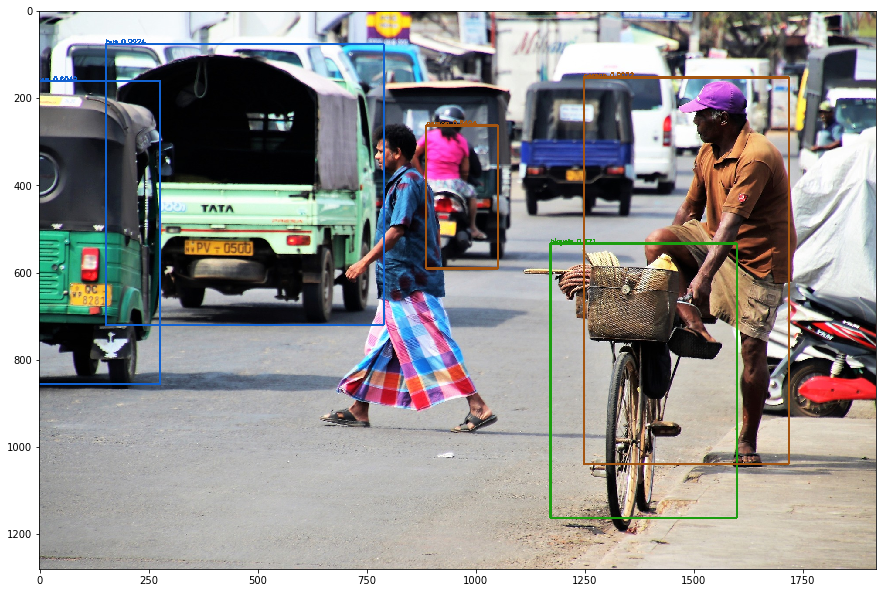

In [4]:
# confidence is used as thresheold for confidence for the detected object.
# this means how the object fitted to detected object
confidence = 0.6

print('Detected: ')
## here we get the data for each detected object in the blob
for detection in out[0,0,:,:]:
    #confidence score
    score = float(detection[2])
    
    #label index
    label_index = int(detection[1])

    # draw rectangle and write the name of the object if above given confidence
    if score > confidence:
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        
        label_text = labels[label_index] +  " " + str(round(score, 4))
        print(label_text)
        cv.putText(resized_img, label_text, (int(left), int(top)), cv.FONT_HERSHEY_SIMPLEX, 0.5, label_colors[label_index], 2)       
        cv.rectangle(resized_img, (int(left), int(top)), (int(right), int(bottom)), label_colors[label_index], thickness=3)

        #original image
        row_factor = orig_rows/300.0  
        col_factor = orig_cols/300.0
        
        # Scale object detection to original image
        left = int(col_factor * left) 
        top = int(row_factor * top)
        right   = int(col_factor * right)
        bottom   = int(row_factor * bottom)
        
        cv.putText(img, label_text, (int(left), int(top)), cv.FONT_HERSHEY_SIMPLEX, 0.5, label_colors[label_index], 2)       
        cv.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), label_colors[label_index], thickness=3)
        
# show image on a window
#cv.imshow('img', img)
#print image on notebook, Cars has been detected
#plt.imshow(cv.cvtColor(resized_img, cv.COLOR_BGR2RGB))
plt.figure(figsize=(15, 15))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#cv.waitKey()

## Tensorflow

Tensorflow is another framework to work on Deep Neural Networks. In this example, as in Caffe, MobileNet SSD will be used, however model has been trained with COCO dataset, therefore it has more labels and slightly better detection.

Here is a simple tutorial for object detection.

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

Tensorflow weights and biases are stored in .pb files, following .gz file includes the pb file. Download tar.gz file and extract it. Copy the **frozen_inference_graph.pb** file to a location you like to use. 

We will use the http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz

ssd_mobilenet_v1_coco, which means model developed using imageset from http://mscoco.net 

Then, we need pbtxt file to get the Neural Network. Then, download the network file pbtxt, which are ready to download from: https://gist.githubusercontent.com/dkurt/45118a9c57c38677b65d6953ae62924a/raw/b0edd9e8c992c25fe1c804e77b06d20a89064871/ssd_mobilenet_v1_coco_2017_11_17.pbtxt

Neural net is Mobile Net and SSD method has been used as in Caffe framework.

Another thing is that each network is trained against a set of images and their labels, these labels are crucial to understand what object has been detected. There fore you also need to get list of labels.

Labels are stored in: https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt you need to parse them and get the ids and names.

MS COCO: https://arxiv.org/pdf/1405.0312.pdf 

```shell
wget -O <path>/ssd_mobilenet_v1_coco_2017_11_17.tar.gz http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz

cd <path>

tar xzvf ssd_mobilenet_v1_coco_2017_11_17.tar.gz

mv ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb .

wget -O <path>/ssd_mobilenet_v1_coco_2017_11_17.pbtxt https://gist.githubusercontent.com/dkurt/45118a9c57c38677b65d6953ae62924a/raw/b0edd9e8c992c25fe1c804e77b06d20a89064871/ssd_mobilenet_v1_coco_2017_11_17.pbtxt
```

In [5]:
# coco labels
# there are 183 labels, all can be find in models/mscoco_labels.txt, below code parses labels to reuse them
tf_labels_file = 'dnn_models/mscoco_labels.txt'

labels = list()

with open(tf_labels_file) as f:
    lines = f.readlines()
    for line in lines:
        items = line.split(': ')
        labels.append(items[1].replace('\n', ''))

print('Number of Labels: '+ str(len(labels)))
        
label_colors = np.random.uniform(0, 255, (len(labels),3))

Number of Labels: 183


In [6]:
# here is the models 
tf_model_file = 'dnn_models/frozen_inference_graph.pb'
tf_config_file = 'dnn_models/ssd_mobilenet_v1_coco_2017_11_17.pbtxt'

tf_net = cv.dnn.readNetFromTensorflow(tf_model_file, tf_config_file)

# Let's define and open an existing image from our resources
source_image = 'resources/street.jpg'
img = cv.imread(source_image)

# Now, we open the image we want to run object detection of MobileNetSSD model.

# First we get image size
rows = img.shape[0]
cols = img.shape[1]

blob = cv.dnn.blobFromImage(img, 1.0/127.5, (300, 300), (127.5, 127.5, 127.5), swapRB=True, crop=False)

# send blob input to neural net 
tf_net.setInput(blob)

# forward method is asking all detected objects
start_time = time.time()
out = tf_net.forward()
end_time = time.time()

print('Inference Time: {} miliseconds'.format(round((end_time - start_time)*1000.0 , 3)))

Inference Time: 76.608 miliseconds


Detected: 
Object - Confidence
person - 0.9587
person - 0.8977
person - 0.3215
bicycle - 0.4049
bus - 0.3189
truck - 0.7203
truck - 0.7105
truck - 0.3707
truck - 0.3176
handbag - 0.4504


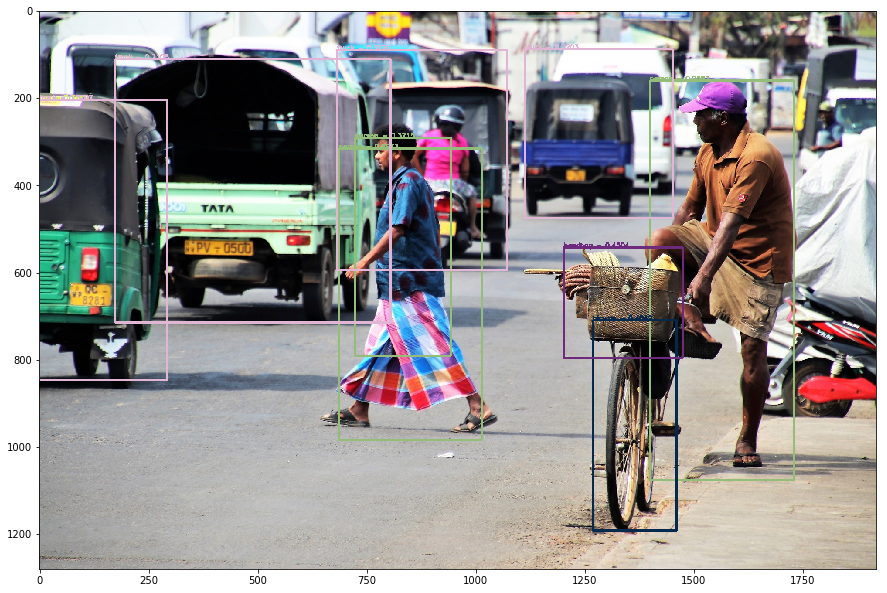

In [7]:

# confidence is used as thresheold for confidence for the detected object.
# this means how the object fitted to detected object
confidence = 0.3

print('Detected: ')
print('Object - Confidence')
## here we get the data for each detected object in the blob

for detection in out[0,0,:,:]:
    score = float(detection[2])
    
    label_idx = int(detection[1])
    
    label_text = str(labels[label_idx]) + " - " + str(round(score, 4))
    
    if score > confidence:
        print(label_text)
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        cv.putText(img, label_text, (int(left), int(top)), cv.FONT_HERSHEY_SIMPLEX, 0.5, label_colors[label_idx], 2)
        cv.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), label_colors[label_idx], thickness=3)
        
# show image on a window
#cv.imshow('img', img)
#print image on notebook, Cars has been detected
plt.figure(figsize=(15, 15))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#cv.waitKey()


### Object recognition with Darknet Yolo

At this part we will try YOLO (You Only Look Once), in previous sections we have used SDD method for image recognition. However, it is possible change methodologies so YOLO is another method works with DarkNet network configuration.

https://pjreddie.com/darknet/yolo/

https://github.com/pjreddie/darknet/wiki/YOLO:-Real-Time-Object-Detection

OpenCV has interface to read network (cfg) and weights, biasses from .weights file.

Download cfg file:

https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2-tiny.cfg 

Download weights:

https://pjreddie.com/media/files/yolov2-tiny.weights

Finally, as mentioned earlier, we need classes, labels to understand what object we have detected.

Download Classes/Labels:

https://raw.githubusercontent.com/pjreddie/darknet/master/data/9k.names

Download Required Material from Terminal:

```shell
wget -O <path>/yolov2-tiny.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2-tiny.cfg 

wget -O <path>/yolov2-tiny.weights https://pjreddie.com/media/files/yolov2-tiny.weights

wget -O <path>/yolov2-labels.txt https://raw.githubusercontent.com/pjreddie/darknet/master/data/9k.names

```


Labels Count: 9418 
DarkNet Inference Time 84.2171 miliseconds
183
Detected: 
Object - Confidence


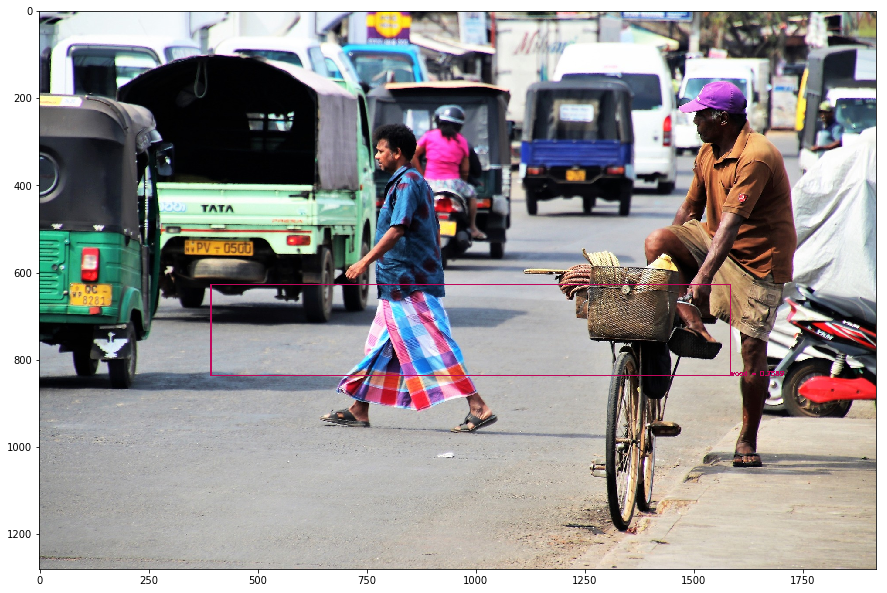

In [8]:
yolo_weights = 'dnn_models/yolov2-tiny.weights'
yolo_config = 'dnn_models/yolov2-tiny.cfg'

yolo_labels_file = 'dnn_models/yolov2-labels.txt'

yolo_labels = list()

with open(yolo_labels_file) as f:
    lines = f.readlines()
    for line in lines:
        yolo_labels.append(items[1].replace('\n', ''))

print('Labels Count: {} '.format(len(yolo_labels)))

yolo_net = cv.dnn.readNetFromDarknet(yolo_config, yolo_weights)

# Let's define and open an existing image from our resources
source_image = 'resources/street.jpg'
img = cv.imread(source_image)

# First we get image size
rows = img.shape[0]
cols = img.shape[1]

blob = cv.dnn.blobFromImage(img, 1.0/255., (224, 224), (104, 117, 123))

# send blob input to neural net 
yolo_net.setInput(blob)

# forward method is asking all detected objects
start_time = time.time()
out = yolo_net.forward()
end_time = time.time()

print('DarkNet Inference Time {} miliseconds'.format(round((end_time - start_time)*1000.0,4)))

# confidence is used as thresheold for confidence for the detected object.
# this means how the object fitted to detected object
confidence = 0.7

print(len(labels))

print('Detected: ')
print('Object - Confidence')
## here we get the data for each detected object in the blob

row_count = out.shape[0]
col_count = out.shape[1]

# sort the indexes of the probabilities in descending order (higher
# probabilitiy first) and grab the top-5 predictions
idx = 0
for detection in out:
    #score = float(detection[2])
    #label_idx = int(detection[1])
    
    score = float(detection[4])
    
    label_idx = idx

    label_text = str(yolo_labels[label_idx]) + " - " + str(round(score, 4))

    if score > confidence:
        #print(label_text)
        left = detection[0] * cols
        top = detection[1] * rows
        right = detection[2] * cols
        bottom = detection[3] * rows
        cv.putText(img, label_text, (int(left), int(top)), cv.FONT_HERSHEY_SIMPLEX, 0.5, label_colors[label_idx], 2)
        cv.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), label_colors[label_idx], thickness=2)

    idx += 1
        
# show image on a window
#cv.imshow('img', img)
#print image on notebook, Cars has been detected
plt.figure(figsize=(15, 15))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#cv.waitKey()

### Real Time Object Detection

You can continue to run RealTimeObjectDetection.py example with following options to see its performance with OpenCV:

1. Runs with a usb webcam, tries to infer all the incoming frames using MobileNetSDD Caffe Model

```shell
python RealTimeOBjectDetection.py -d cpu -i live -f caffe --mconfig dnn_models/MobileNetSSD_deploy.prototxt --mweight dnn_models/MobileNetSSD_deploy.caffemodel --mlabels dnn_models/caffe_ssd_labels.txt --model_image_height 300 --model_image_width 300 -c 0.65 
```

2. Runs with a usb webcam, tries to infer only 4 frames within the incoming frames per second using MobileNetSDD Caffe Model

```shell
python RealTimeOBjectDetection.py -d cpu -i live -f caffe --mconfig dnn_models/MobileNetSSD_deploy.prototxt --mweight dnn_models/MobileNetSSD_deploy.caffemodel --mlabels dnn_models/caffe_ssd_labels.txt --model_image_height 300 --model_image_width 300 -c 0.65 --infer_fc 4
```

3. Reads frames from .mp4 file and infers 4 frames per second.

```shell
python RealTimeOBjectDetection.py -d cpu -i offline -s resources/video.mp4 -f caffe --mconfig dnn_models/MobileNetSSD_deploy.prototxt --mweight dnn_models/MobileNetSSD_deploy.caffemodel --mlabels dnn_models/caffe_ssd_labels.txt --model_image_height 300 --model_image_width 300 -c 0.65 --infer_fc 4
```